## AutoML-FLAML サンプルコード

In [1]:
%load_ext lab_black

In [2]:
# ライブラリーのインポート
import os

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# ボストンの住宅価格データ
from sklearn.datasets import load_boston

# 前処理
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# flaml
import flaml
from flaml import AutoML
from flaml.data import get_output_from_log
from flaml.ml import sklearn_metric_loss_score

# 評価指標
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [3]:
print(flaml.__version__)

0.6.0


In [4]:
# データセットの読込み
boston = load_boston()

# 説明変数の格納
df = pd.DataFrame(boston.data, columns=boston.feature_names)
# 目的変数の追加
df["MEDV"] = boston.target

# データの中身を確認
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [5]:
# ランダムシード値
RANDOM_STATE = 10

# 学習データと評価データの割合
TEST_SIZE = 0.2

# 学習データと評価データを作成
x_train, x_test, y_train, y_test = train_test_split(
    df.iloc[:, 0 : df.shape[1] - 1],
    df.iloc[:, df.shape[1] - 1],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
)

In [6]:
# flamlのパラメータ設定
automl_settings = {
    "time_budget": 120,
    "metric": "r2",
    "task": "regression",
    "ensemble": False,
    "split_type": "stratified",
    "n_splits": 5,
    "seed": 10,
    "log_file_name": "boston.log",
}

In [7]:
# flaml学習
automl = AutoML()
automl.fit(X_train=x_train, y_train=y_train, **automl_settings)

[flaml.automl: 08-30 09:57:47] {1219} INFO - Evaluation method: cv
[flaml.automl: 08-30 09:57:47] {698} INFO - Using RepeatedKFold
[flaml.automl: 08-30 09:57:47] {1250} INFO - Minimizing error metric: 1-r2
[flaml.automl: 08-30 09:57:47] {1274} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree']
[flaml.automl: 08-30 09:57:47] {1457} INFO - iteration 0, current learner lgbm
[flaml.automl: 08-30 09:57:47] {1614} INFO -  at 0.5s,	best lgbm's error=0.6302,	best lgbm's error=0.6302
[flaml.automl: 08-30 09:57:47] {1457} INFO - iteration 1, current learner lgbm
[flaml.automl: 08-30 09:57:48] {1614} INFO -  at 0.7s,	best lgbm's error=0.6302,	best lgbm's error=0.6302
[flaml.automl: 08-30 09:57:48] {1457} INFO - iteration 2, current learner lgbm
[flaml.automl: 08-30 09:57:48] {1614} INFO -  at 0.9s,	best lgbm's error=0.3550,	best lgbm's error=0.3550
[flaml.automl: 08-30 09:57:48] {1457} INFO - iteration 3, current learner lgbm
[flaml.automl: 08-30 09:57:4

ベストなモデルとハイパーパラメータの確認

In [8]:
print("Best ML leaner:", automl.best_estimator)
print("Best hyperparmeter config:", automl.best_config)
print("Best accuracy on validation data: {0:.4g}".format(1 - automl.best_loss))
print("Training duration of best run: {0:.4g} s".format(automl.best_config_train_time))

Best ML leaner: extra_tree
Best hyperparmeter config: {'n_estimators': 38, 'max_features': 0.5779834677310134, 'max_leaves': 167}
Best accuracy on validation data: 0.888
Training duration of best run: 0.5215 s


In [9]:
# モデルのインスタンスを確認
automl.model.estimator

ExtraTreesRegressor(max_features=0.5779834677310134, max_leaf_nodes=167,
                    n_estimators=38, n_jobs=-1)

In [10]:
# flaml推論
y_pred = automl.predict(x_test)

In [11]:
# 評価
def calculate_scores(true, pred):
    """全ての評価指標を計算する

    Parameters
    ----------
    true (np.array)       : 実測値
    pred (np.array)       : 予測値

    Returns
    -------
    scores (pd.DataFrame) : 各評価指標を纏めた結果

    """
    scores = {}
    scores = pd.DataFrame(
        {
            "R2": r2_score(true, pred),
            "MAE": mean_absolute_error(true, pred),
            "MSE": mean_squared_error(true, pred),
            "RMSE": np.sqrt(mean_squared_error(true, pred)),
        },
        index=["scores"],
    )
    return scores

In [12]:
scores = calculate_scores(y_test, y_pred)
print(scores)

              R2       MAE        MSE      RMSE
scores  0.874187  2.559465  13.157632  3.627345


モデルの探索過程を可視化

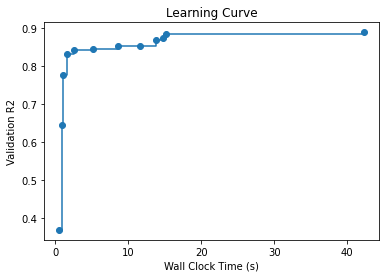

In [13]:
(
    time_history,
    best_valid_loss_history,
    valid_loss_history,
    config_history,
    train_loss_history,
) = get_output_from_log(filename=automl_settings["log_file_name"], time_budget=120)

plt.title("Learning Curve")
plt.xlabel("Wall Clock Time (s)")
plt.ylabel("Validation R2")
plt.scatter(time_history, 1 - np.array(valid_loss_history))
plt.step(time_history, 1 - np.array(best_valid_loss_history), where="post")
plt.show()